# 特徴量作成と選択の自動化
### House Prices: Advanced Regression Techniques

In [1]:
% matplotlib inline

from __future__ import print_function

import copy

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import mean_squared_error

C:\Users\Hiroshi.Hiromax\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## データの読み込み

In [2]:
data = pd.read_csv("dataset/ML_project_train3.csv")

In [3]:
# NANに平均値を割り当て
train_col = ['LotFrontage']
for col in train_col:
    data[col] = data[col].fillna(data[col].mean())

In [4]:
# NANに0を割り当て
# 平均値でNANを穴埋め
train_col = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea']
for col in train_col:
    data[col] = data[col].fillna(0)

In [5]:
# 最頻値を割り当て
train_col = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']
for col in train_col:
    dic = {}
    Index = data[col].value_counts(dropna=False).index
    for n in range(0,len(Index)):
        dic[data[col].value_counts(dropna=False).values[n]] = Index[n]
    data[col] = data[col].fillna(dic[max(dic)])

In [6]:
# NoでNANを穴埋め
train_col = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType'
             ,'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
for col in train_col:
    data[col] = data[col].fillna('NO')

In [105]:
dummy_data_ot = pd.get_dummies(data[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'
                                     ,'FireplaceQu','PoolQC','Fence','MiscFeature']], drop_first = True) 

In [106]:
dummy_data_ot.head()

,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NO,BsmtQual_TA,BsmtCond_Gd,BsmtCond_NO,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,...,PoolQC_Gd,PoolQC_NO,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NO,MiscFeature_NO,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0
1,0,1,0,0,0,0,0,1,1,0,...,0,1,0,0,0,1,1,0,0,0
2,0,1,0,0,0,0,0,1,0,1,...,0,1,0,0,0,1,1,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0


In [107]:
# ダミー変数作成
dummy_col = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood'
                                   ,'Condition1','Condition2','BldgType','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType'
                                   ,'HouseStyle','FireplaceQu','PoolQC','Fence','MiscFeature','ExterQual','ExterCond','Foundation','Heating'
                                   ,'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual'
                                   ,'GarageCond','PavedDrive','SaleType','SaleCondition']
#dummy_data = pd.get_dummies(data[dummy_col], drop_first = True) 
dummy_data = pd.get_dummies(data[dummy_col], drop_first = True) 
#FireplaceQu,'PoolQC','Fence','MiscFeature'

In [108]:
data2 = pd.merge(data, dummy_data, left_index=True, right_index=True)
data2 = pd.merge(data2, dummy_data_ot, left_index=True, right_index=True)

In [109]:
data2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC_Gd_y,PoolQC_NO_y,Fence_GdWo_y,Fence_MnPrv_y,Fence_MnWw_y,Fence_NO_y,MiscFeature_NO_y,MiscFeature_Othr_y,MiscFeature_Shed_y,MiscFeature_TenC_y
0,1,60,RL,65.0,8450,Pave,NO,Reg,Lvl,AllPub,...,0,1,0,0,0,1,1,0,0,0
1,2,20,RL,80.0,9600,Pave,NO,Reg,Lvl,AllPub,...,0,1,0,0,0,1,1,0,0,0
2,3,60,RL,68.0,11250,Pave,NO,IR1,Lvl,AllPub,...,0,1,0,0,0,1,1,0,0,0
3,4,70,RL,60.0,9550,Pave,NO,IR1,Lvl,AllPub,...,0,1,0,0,0,1,1,0,0,0
4,5,60,RL,84.0,14260,Pave,NO,IR1,Lvl,AllPub,...,0,1,0,0,0,1,1,0,0,0


In [48]:
data['PoolQC'].head()

0    No
1    No
2    No
3    No
4    No
Name: PoolQC, dtype: object

In [10]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,12,2008,WD,Normal,12.429216


In [7]:
# 整数値を割り当て
train_col = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1'
             ,'Condition2','BldgType','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','HouseStyle','FireplaceQu'
             ,'PoolQC','Fence','MiscFeature','ExterQual','ExterCond','Foundation','Heating','HeatingQC','CentralAir','Electrical'
             ,'KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive'
            ,'PoolQC','Fence','MiscFeature','SaleType','SaleCondition','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
for col in train_col:
    Index = data[col].value_counts(dropna=False).index
    for n1 in range(0,len(Index)):
        for n in range(0,len(data[col])):
            if data.loc[n,col] == Index[n1]:
                data.loc[n,col] = n1+1

In [923]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,1,65.0,8450,1,1,1,1,1,...,0,1,1,1,0,2,2008,1,1,12.247694
1,2,20,1,80.0,9600,1,1,1,1,1,...,0,1,1,1,0,5,2007,1,1,12.109011
2,3,60,1,68.0,11250,1,1,2,1,1,...,0,1,1,1,0,9,2008,1,1,12.317167
3,4,70,1,60.0,9550,1,1,2,1,1,...,0,1,1,1,0,2,2006,1,3,11.849398
4,5,60,1,84.0,14260,1,1,2,1,1,...,0,1,1,1,0,12,2008,1,1,12.429216


## ターゲット変数と特徴量を指定

In [9]:
target_col = 'SalePrice'
#feature_cols = ['MSSubClass','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','YrSold','1stFlrSF','2ndFlrSF','LowQualFinSF'
 #               ,'GrLivArea','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','WoodDeckSF','OpenPorchSF'
  #             ,'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'
   #            ,'BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea','Street','LotShape','Alley','FireplaceQu','LotFrontage','PoolQC'
    #            ,'Fence','MiscFeature','MSZoning','MasVnrType','Utilities','MasVnrArea','LandContour','LotConfig','LandSlope','Neighborhood'
     #          ,'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','ExterQual','ExterCond'
      #         ,'Foundation','Heating','HeatingQC','CentralAir','Electrical','SaleType','SaleCondition','PavedDrive','Functional'
       #         ,'KitchenQual','GarageType','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond']
exclude_cols = ['SalePrice', 'Id', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2'
               ,'BsmtUnfSF','TotalBsmtSF','GarageYrBlt','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood'
                                   ,'Condition1','Condition2','BldgType','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType'
                                   ,'HouseStyle','FireplaceQu','PoolQC','Fence','MiscFeature','ExterQual','ExterCond','Foundation','Heating'
                                   ,'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual'
                                   ,'GarageCond','PavedDrive','SaleType','SaleCondition','FireplaceQu','PoolQC','Fence','MiscFeature'
               ,'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
feature_cols = [col for col in data.columns if col not in exclude_cols]

## 特徴量を割り算で作成

In [10]:
cutoff_r = 0.5
new_added_col = []
for i in range(0, len(feature_cols)-1):
    for j in range(i+1, len(feature_cols)):
        first_col_name = feature_cols[i]
        second_col_name = feature_cols[j]
        r = spearmanr(data[first_col_name], data[second_col_name]).correlation
        if abs(r) > cutoff_r:
            new_colname = first_col_name + "_div_" + second_col_name
            data[new_colname] = data[first_col_name] / (data[second_col_name] + 0.01)
            new_added_col.append(new_colname)

In [11]:
feature_cols = feature_cols + new_added_col

## ランダムフォレストによる特徴量の絞り込み

In [12]:
y = np.array(data[target_col])
X = np.array(data[feature_cols])

In [13]:
X_train, X_test, y_train, y_test = \
 train_test_split(X, y, test_size=0.3, random_state=1234)

In [14]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [15]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [16]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [19]:
ypred = rf.predict(X_test)

In [20]:
print("Root Means Square:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=ypred)))

Root Means Square: 0.152564039486


In [21]:
rf.feature_importances_.max()

0.27244778233987527

In [119]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NO,Reg,Lvl,AllPub,...,0,NO,NO,NO,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NO,Reg,Lvl,AllPub,...,0,NO,NO,NO,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NO,IR1,Lvl,AllPub,...,0,NO,NO,NO,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NO,IR1,Lvl,AllPub,...,0,NO,NO,NO,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NO,IR1,Lvl,AllPub,...,0,NO,NO,NO,0,12,2008,WD,Normal,12.429216


## 変数の重要度の確認

In [22]:
def varImpPlot(clf, feature_names, topN = 30, verbose = True):
    feature_names = np.array(feature_names)
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    
    topN_feature = feature_importance[sorted_idx][len(feature_importance) - topN:]
    topN_feature_name = feature_names[sorted_idx][len(feature_importance) - topN:]
    pos = np.arange(topN) + .5
    plt.barh(pos, topN_feature, align='center')
    plt.yticks(pos, topN_feature_name)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    rev_sorted_idx = np.argsort(feature_importance)[::-1]
    if verbose:
        for i, v in zip(feature_names[rev_sorted_idx], feature_importance[rev_sorted_idx]):
            print(i, v)

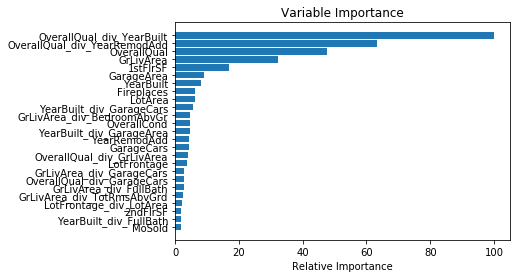

In [23]:
varImpPlot(rf, feature_cols, topN=25, verbose=False)

## 一定の重要度がなければ削除して再度モデル構築

In [172]:
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_cols_ar = np.array(feature_cols)
new_feature_cols = feature_cols_ar[feature_importance > 0.3]

C:\Users\Hiroshi.Hiromax\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 270 but corresponding boolean dimension is 14
  after removing the cwd from sys.path.


In [173]:
len(new_feature_cols)

11

In [174]:
len(feature_cols)

270

In [175]:
y = np.array(data2[target_col])
X = np.array(data2[new_feature_cols])

In [176]:
X_train, X_test, y_train, y_test = \
 train_test_split(X, y, test_size=0.3, random_state=1234)

In [177]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)

In [178]:
print("Root Means Square:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=ypred)))

Root Means Square: 0.159401817482


## 予測

In [159]:
test_data = pd.read_csv("dataset/ML_project_test.csv")

In [160]:
# NANに平均値を割り当て
train_col = ['LotFrontage']
for col in train_col:
    test_data[col] = test_data[col].fillna(test_data[col].mean())

In [161]:
# NANに0を割り当て
# 平均値でNANを穴埋め
train_col = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea']
for col in train_col:
    test_data[col] = test_data[col].fillna(0)

In [162]:
# 最頻値を割り当て
train_col = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']
for col in train_col:
    dic = {}
    Index = test_data[col].value_counts(dropna=False).index
    for n in range(0,len(Index)):
        dic[test_data[col].value_counts(dropna=False).values[n]] = Index[n]
    test_data[col] = test_data[col].fillna(dic[max(dic)])

In [163]:
# NoでNANを穴埋め
train_col = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType'
             ,'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
for col in train_col:
    test_data[col] = test_data[col].fillna('NO')

In [164]:
# ダミー変数作成
dummy_col = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood'
                                   ,'Condition1','Condition2','BldgType','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType'
                                   ,'HouseStyle','FireplaceQu','PoolQC','Fence','MiscFeature','ExterQual','ExterCond','Foundation','Heating'
                                   ,'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual'
                                   ,'GarageCond','PavedDrive','SaleType','SaleCondition']
#dummy_data = pd.get_dummies(data[dummy_col], drop_first = True) 
dummy_data = pd.get_dummies(test_data[dummy_col], drop_first = True) 
#FireplaceQu,'PoolQC','Fence','MiscFeature'

In [165]:
dummy_data_ot = pd.get_dummies(test_data[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'
                                     ,'FireplaceQu','PoolQC','Fence','MiscFeature']], drop_first = True) 

In [166]:
test_data2 = pd.merge(test_data, dummy_data, left_index=True, right_index=True)
test_data2 = pd.merge(test_data2, dummy_data_ot, left_index=True, right_index=True)
test_data2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,FireplaceQu_TA_y,PoolQC_Gd_y,PoolQC_NO_y,Fence_GdWo_y,Fence_MnPrv_y,Fence_MnWw_y,Fence_NO_y,MiscFeature_NO_y,MiscFeature_Othr_y,MiscFeature_Shed_y
0,1461,20,RH,80.0,11622,Pave,NO,Reg,Lvl,AllPub,...,0,0,1,0,1,0,0,1,0,0
1,1462,20,RL,81.0,14267,Pave,NO,IR1,Lvl,AllPub,...,0,0,1,0,0,0,1,0,0,0
2,1463,60,RL,74.0,13830,Pave,NO,IR1,Lvl,AllPub,...,1,0,1,0,1,0,0,1,0,0
3,1464,60,RL,78.0,9978,Pave,NO,IR1,Lvl,AllPub,...,0,0,1,0,0,0,1,1,0,0
4,1465,120,RL,43.0,5005,Pave,NO,IR1,HLS,AllPub,...,0,0,1,0,0,0,1,1,0,0


In [912]:
# 整数値を割り当て
train_col = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1'
             ,'Condition2','BldgType','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','HouseStyle','FireplaceQu'
             ,'PoolQC','Fence','MiscFeature','ExterQual','ExterCond','Foundation','Heating','HeatingQC','CentralAir','Electrical'
             ,'KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive'
            ,'PoolQC','Fence','MiscFeature','SaleType','SaleCondition']
for col in train_col:
    Index = test_data[col].value_counts(dropna=False).index
    for n1 in range(0,len(Index)):
        for n in range(0,len(test_data[col])):
            if test_data.loc[n,col] == Index[n1]:
                test_data.loc[n,col] = n1+1

In [167]:
ypred = rf.predict(test_data2[new_feature_cols])

In [168]:
ypred = pd.DataFrame(ypred)

In [169]:
ypred.to_csv("dataset/result_ML7.csv")

In [874]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)